## E9 - Grupo 3
## Car Price Prediction
Predecir si el precio de un carro es bajo o alto

In [165]:
%matplotlib inline
import pandas as pd
import numpy as np

data = pd.read_csv('dataTrain_carListings.csv')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [166]:
data.shape

(13150, 10)

In [167]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [168]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Ejercicio 8.1
Estimar un árbol de decisión manualmente utilizando decision trees notebook (cada variable separada en 10 percentiles).

Evaluar accuracy en el set de test.


In [169]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [170]:
def gini_impurity(X_col, y, split):
      
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

#### Función que encuentra el mejor punto de corte para cada variable predictora
Identificar el punto de corte para cada variable utilizando el Gini como el criterio de decisión (Es decir el punto de corte de la variable que minimice la probabilidad que un dato en un nodo, seleccionado al azar, esté mal clasificado)

In [171]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

#### Crear el arbol
Identificar primero la variable que haga que el Gini sea inferior. Empezar el árbol por esa variable (primer nivel), quitar esa variable y repetir para encontrar el segundo nivel, tercer nivel ... hasta el máx_depth, que en este caso seleccionaremos como el número de variables que tenemos para los carros.

In [172]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [173]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=len(X.columns), num_pct=10)

In [178]:
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': [2, 1.0],
    'n_samples': 98,
    'gain': 0.01707452211653898,
    'sl': {'y_pred': 0,
     'y_prob': 0.04597701149425287,
     'level': 4,
     'split': [1, 37722.0],
     'n_samples': 85,
     'gain': 0.001980228771650633,
     'sl': {'y_pred': 0,
      'y_prob': 0.12,
      'level': 5,
      'split': [1, 33000.0],
      'n_samples': 23,
      'gain': 0.03456656764785304,
      'sl': {'y_pred': 0,
       'y_prob': 0.05555555555555555,
       'level': 6,
       'split': -1,
       'n_sam

Del árbol creado, identificamos que el primer nivel de son las millas del vehiculo y el segundo,  el año del carro. Algo interesante es que estás variables vuelven a aparecer en siguientes niveles, lo que nos permite sospechar que probablemente son variables predictoras de alta importancia para clasificar el costo del carro (bajo/alto).

#### Predicción del Precio del Carro
Utilizar el árbol creado para identificar si el precio del carro es bajo o alto, dadas las caracteristicas del carro (eg, año, distancia acumulada (millas), etc.)

In [179]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [180]:
y_predict_dt = tree_predict(X_test, tree)

#### Evaluación de accuracy en el set de entrenamiento

In [181]:
accuracy_d_tree = np.sum(np.equal(y_test,y_predict_dt))/len(y_test)

In [182]:
accuracy_d_tree

0.8728110599078341

## Ejercicio 8.2
Ensamblar 10 árboles de clasificación manualmente (Utilizando bagging notebook).
Evaluar accuracy en el set de test.


In [183]:
np.random.seed(123)
#Número de muestras que tendremos para crear cada árbol (debe ser del mismo tamaño de la muestra original)
n_samples = y_train.shape[0]

#número de Arboles
n_B = 100

# creación de 10 muestras (con remplazo)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [184]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [185]:
# grow each tree deep
treereg = DecisionTreeClassifier(max_depth=len(X.columns), random_state=123)

# DataFrame for storing predicted price from each tree
y_pred_b = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

In [186]:
# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_train_b = X_train.iloc[samples[i]]
    y_train_b = y_train.iloc[samples[i]]
    treereg.fit(X_train_b, y_train_b)
    y_pred_b.iloc[:,i] = treereg.predict_proba(X_test)[:,1]

In [187]:
y_pred_b=pd.DataFrame(y_pred_b)


In [188]:
y_pred_bagging=np.where(y_pred_b.mean(axis=1)<=0.5,0,1)

In [189]:
metrics.accuracy_score(y_pred_bagging, y_test)

0.8771889400921659

#### Conclusión Ensamblaje: 
El accuracy para nuestro ensamble de 10 arboles (0.87718) es superior que el accuracy para un solo árbol (0.87281). Esto demuestra el teorema de 'Condorcet's Jury,' donde esperamos que al combinar el resultado de múltiples modelos de predicción (clasificadores de árboles de decisión de una única base (single decision tree)), logremos un modelo con mejor rendimiento (mejor poder de predicción).

## Ejercicio 8.3
Comparar el impacto de cambiar el parámetro 'Max_features.'

Evaluar accuracy en el set de test.


Utilizamos el paquete Sklearn para evaluar el efecto de la variable 'Max_features', es decir, cuantas variables incuiremos en nuestro arbol de decisión.

In [190]:
from sklearn.tree import DecisionTreeClassifier   

In [191]:
feature_range = range(1, len(X_test.columns)+1)
accuracy_scores = []

# use 5-fold cross-validation with each value of max_features
for feature in feature_range:
    clf = DecisionTreeClassifier(max_features=feature, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

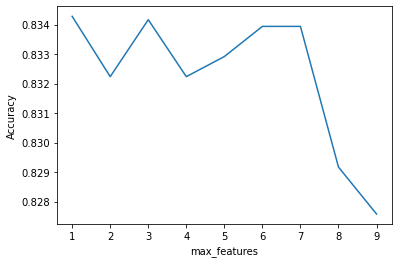

In [192]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

En la gráfica vemos el efecto de aumentar el número de variables incluidas. Identificamos que el valor que máximiza el accuracy es 3. Que de hecho, cumple con la 'rule of thump' para los arboles de clasificación m=sqr(p) donde m es el número de variables a utilizar en el modelo y p el número de variables que tenemos (en este caso, para los carros).

Ahora vamos a probar en un ensamble de 10 arboles si efectivamente el útilizar este valor óptimo nos da un mejor accuracy de nuestro modelo, para ello compararemos el modelo con max_features igual a su valor default vs. el valor de máx features encontrado (3

In [193]:
np.random.seed(321)

n_estimators = 10
n_samples = X_train.shape[0]

#Muestras bootstrap
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [194]:
from sklearn import metrics

#### max_features = None (Valor Default), max_features = n_features.

In [195]:
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features=None, max_depth=len(X.columns), random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [196]:
#Predicción
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)
    

In [197]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [198]:
metrics.accuracy_score(y_pred, y_test)

0.8746543778801843

#### max_features = 3

In [229]:
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features=3, max_depth=len(X.columns), random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [230]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

In [231]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [232]:
from sklearn import metrics
metrics.accuracy_score(y_pred, y_test)

0.8806451612903226

#### Conclusión: 
La intuición diría que un mejor modelo será aquel que tenga más variables. Sin embargo, fue interesante identificar que no es así. Una posible explicación puede ser el efecto que pueden tener de overfiting de variables y además, que el modelo realmente solo necesita aquellas variables que aporten fuertemente a la predicción.

El parámetro 'Máx features' establece el número de variables que se incluiran en los arboles (algo así como las hojas del arbol).  encontramos que efectivamente el accuracy es mejor cuando calibramos nuestro modelo con la variable max_features.

## Ejercicio 8.4
Ensamblar 10 arboles con Bagging y con 'Max_features'= log(n_features).
Evaluar accuracy en el set de test.

In [203]:
np.random.seed(123)

n_estimators = 10
n_samples = X_train.shape[0]

#Muestras bootstrap
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [204]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="log2", max_depth=len(X.columns), random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [205]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

In [206]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [207]:
from sklearn import metrics
metrics.accuracy_score(y_pred, y_test)

0.8806451612903226

#### Conclusión:
El valor del accuracy nos dió igual al que encontramos maximizando para máx features. Es decir, log(n_features) también puede ser una buena aproximación para arboles de clasificación.

## Ejercicio 8.5
Utilizar sklearn para entrenar un modelo de Random Forest.
Evaluar el accuracy en el set de test.


In [208]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfcl = RandomForestClassifier()

In [209]:
rfcl.fit(X_train, y_train)
y_pred_rf = rfcl.predict(X_test)
metrics.accuracy_score(y_pred_rf, y_test.values)

0.8380184331797235

Con los valores default de Random Forest encontramos que el accuracy es inferior al que obtuvimos con Bagging.

## Ejercicio 8.6
Encontrar los mejores parámetros para: max_depth, max_features y n_estimators
Evaluar el accuracy en el set de test.

Evaluate the accuracy on the testing set


#### Profundidad, hojas, del árbol

In [210]:
# list of values to try for max_depth
max_depth_range = range(1, 10)
accuracy_scores = []

for depth in max_depth_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

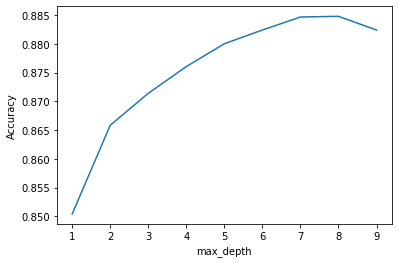

In [211]:
# plot max_depth (x-axis) versus Accuracy (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

Identificamos que la profundidad del árbol que máximiza el accuracy es 8.

#### Identificar Número de Árboles

Para Random Forest, primero queremos determinar cual es el número de árboles (n_estimators) que maximiza el accuracy.

In [212]:
estimator_range = range(1, 50, 1)
accuracy_scores = []

# muestras por 5-fold cross-validation 
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

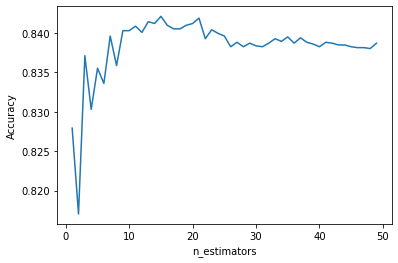

In [213]:
import matplotlib.pyplot as plt

plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

Identificamos que el número de árboles que maximiza el accuracy es 22. Ahora buscaremos el máximo número de variables para crear los arboles.

In [214]:
# list of values to try for max_features
feature_range = range(1, len(X_test.columns)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 5-fold cross-validation with each value of max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=23, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

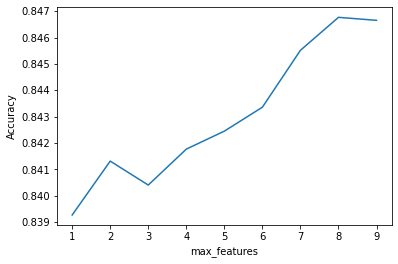

In [215]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

Con la gráfica podemos identificar que debemos utilizar todas las variables (9) que tenemos para los carros.

#### Fit del Random Forest con los parámetros seleccionados

In [239]:
# max_features=9, n_estimators=20 y max_depth=8
clf = RandomForestClassifier(n_estimators=23, max_features=9, max_depth=7, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=9, n_estimators=23, n_jobs=-1,
                       random_state=1)

In [240]:
y_pred_rf = clf.predict(X_test)

In [241]:
metrics.accuracy_score(y_pred_rf, y_test)

0.8790322580645161

## Ejercicio 8.7
Utilizar xgBoost para entrenar un XGBClassifier.

Evaluar el accuracy en el set de test.


In [219]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [220]:
from xgboost import XGBClassifier

clx = XGBClassifier(random_state=20)
clx

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=20, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [221]:
clx.fit(X_train, y_train)
y_pred_xgb = clx.predict(X_test)
metrics.accuracy_score(y_pred_xgb, y_test.values)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8790322580645161

Al ajustar un modelo de XGBoost con los parámetros por default, se evidencia que el accuracy es superior al que habiamos obtenido con Random Forest.

## Ejercicio 8.8
Modificar los parámetros learning rate, gamma, colsample_bytree. Explicar que significa cada parámetro.

Evaluate the accuracy on the testing set


#### Explicación de los parámetros:

Learning rate: El aumento de gradiente implica la creación y la adición de árboles al modelo de forma secuencial. Se crean árboles nuevos para corregir los errores residuales en las predicciones de la secuencia de árboles existente. El efecto es que el modelo puede ajustarse rápidamente y luego sobre-ajustarse al conjunto de datos de entrenamiento.

Una técnica para ralentizar el aprendizaje en el modelo de aumento de gradiente es aplicar una tasa de aprendizaje o learning rate para las correcciones de nuevos árboles cuando se agregan al modelo.

Gamma: Es un parámetro de regularización, el cual funciona usando información "de los árboles". Al ajustar gamma, se agregan nodos a los árboles, esto debería realizarse solo si la ganancia asociada es mayor o igual al costo de complejidad creado por introducir nodos u hojas adicionales, de lo contrario se ve afectada la precisión del modelo.

Colsample_bytree: es la proporción de submuestra de columnas al construir cada árbol. El submuestreo ocurre una vez por cada árbol construido. Este parámetro tiene un rango de (0, 1], el valor predeterminado es 1 y especifica la fracción de columnas a las cuales se les hará submuestreo.

Para escoger el mejor valor en cada parámetro, se realizará una grilla para cada una y con el uso de la función RandomizedSearchCV de sklearn se iterará en todas las combinaciones posibles para encontrar los mejores valores en terminos de accuracy, como se evidencia a continuación.


In [222]:
from sklearn.model_selection import RandomizedSearchCV

#### Grilla y calibración de parámetros

In [223]:
clf_xgb = XGBClassifier(objective = 'binary:logistic')

param_dist = {'colsample_bytree': [0.01, 0.1, 0.2, 0.5, 0.8, 1],
              'learning_rate': [0.01, 0.1, 0.2, 0.5, 0.8, 1],
              'gamma': [0.01, 0.1, 0.2, 5, 10, 50, 100],
             }

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = 5,  
                         n_iter = 5, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'accuracy', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1,
                         random_state=20)

In [224]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    3.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5, error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_e...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                          

#### Mejores parámetros

In [225]:
clf.best_params_, clf.best_score_ 

({'learning_rate': 0.8, 'gamma': 10, 'colsample_bytree': 0.01},
 0.8827468785471055)

#### Aplicar mejor parámetros encontrados

In [226]:
clf = XGBClassifier(learning_rate= 0.8, gamma= 10, colsample_bytree= 0.01)
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.01, gamma=10,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.8, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [227]:
clf.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)], 
        eval_metric=['aucpr', 'auc'],  
        early_stopping_rounds = 30)

[0]	validation_0-aucpr:0.59459	validation_0-auc:0.51737	validation_1-aucpr:0.59626	validation_1-auc:0.51474
[1]	validation_0-aucpr:0.64850	validation_0-auc:0.64868	validation_1-aucpr:0.64961	validation_1-auc:0.64645
[2]	validation_0-aucpr:0.69666	validation_0-auc:0.67604	validation_1-aucpr:0.69707	validation_1-auc:0.67354
[3]	validation_0-aucpr:0.70066	validation_0-auc:0.68515	validation_1-aucpr:0.70088	validation_1-auc:0.68236
[4]	validation_0-aucpr:0.91194	validation_0-auc:0.90054	validation_1-aucpr:0.91570	validation_1-auc:0.90416
[5]	validation_0-aucpr:0.92096	validation_0-auc:0.90549	validation_1-aucpr:0.92458	validation_1-auc:0.90939
[6]	validation_0-aucpr:0.92096	validation_0-auc:0.90549	validation_1-aucpr:0.92458	validation_1-auc:0.90939
[7]	validation_0-aucpr:0.92096	validation_0-auc:0.90549	validation_1-aucpr:0.92458	validation_1-auc:0.90939
[8]	validation_0-aucpr:0.92616	validation_0-auc:0.91127	validation_1-aucpr:0.93187	validation_1-auc:0.91646
[9]	validation_0-aucpr:0.926

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.01, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.8, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Accuracy

In [228]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_pred, y_test.values)

[22:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8815668202764977

#### Conclusión:

Se evidencia que al realizar la calibración del modelo teniendo en cuenta learning rate, gamma, colsample_bytree, logramos mejorar el accuracy con respecto a todos los modelos anteriormente realizados.

### Conclusión Car Price Prediction

#### Modelo...............................................................Accuracy

XGBoost Calibrado........................................... 0.88156682

Ensamble 10 Arboles, Calibrar Max Features... 0.880645161

Ensamble 10 Arboles, Max Features Log(p).....	 0.880645161

XGBoost Default............................................... 0.879032258

Random Forest Calibrado	................................ 0.877419355

Ensamble 10 Arboles	....................................... 0.8771889

Arbol Decisión................................................... 0.872811

Random Forest Default..................................... 0.838018433




Con los resultados obtenidos podemos concluir que XGBoost calibrado es el modelo que mejor nos permite predecir el precio de un carro a partir de las variables del vehiculo.
Adicionalmente, 

-los modelos calibrados funcionan muchisimo mejor que utilizarlos con sus valores default.

-Los modelos con ensambles de arboles funcionan generalmente mejor que un arbol de decisión, ‘The wisdom of the crowd.’